c:\Users\david\Desktop\112-2_deeplearning\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


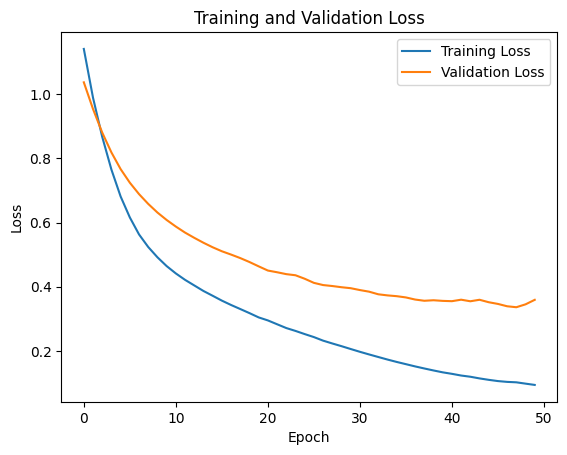

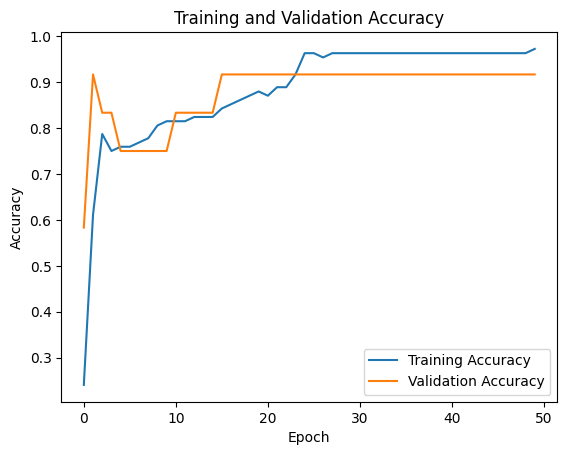

ValueError: The layer sequential_5 has never been called and thus has no defined input.

In [6]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 加載 Iris 資料集
iris = load_iris()
X, y = iris.data, iris.target

# 將資料集劃分為訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 標準化資料
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 創建簡單的神經網絡模型（原始任務）
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(4,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')  # 輸出層，3個類別
])

# 編譯模型
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 訓練模型
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=0)

# 繪製訓練和驗證損失
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 繪製訓練和驗證準確度
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 將原始模型的中間層作為新模型的特徵提取器
# 在創建 feature_extractor 之前，先對 model 進行一次預測
# model.predict(X_train_scaled[0:1])

# 將原始模型的中間層作為新模型的特徵提取器
feature_extractor = tf.keras.Model(inputs=model.input, outputs=model.get_layer(index=1).output)

# 凍結特徵提取器的權重
feature_extractor.trainable = False

# 創建新的分類器模型（目標任務）
# new_model = tf.keras.Sequential([
#     feature_extractor,
#     tf.keras.layers.Dense(32, activation='relu'),
#     tf.keras.layers.Dense(3, activation='softmax')  # 輸出層，3個類別
# ])

# 創建新的分類器模型（目標任務）
inputs = tf.keras.Input(shape=(4,))
features = feature_extractor(inputs)
x = tf.keras.layers.Dense(32, activation='relu')(features)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)
new_model = tf.keras.Model(inputs=inputs, outputs=outputs)

# 編譯新模型
new_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# 訓練新模型
history_new = new_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=0)

# 繪製訓練和驗證損失
plt.plot(history_new.history['loss'], label='Training Loss')
plt.plot(history_new.history['val_loss'], label='Validation Loss')
plt.title('New Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 繪製訓練和驗證準確度
plt.plot(history_new.history['accuracy'], label='Training Accuracy')
plt.plot(history_new.history['val_accuracy'], label='Validation Accuracy')
plt.title('New Model Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 評估新模型
test_loss, test_acc = new_model.evaluate(X_test_scaled, y_test, verbose=2)
print('\nTest accuracy:', test_acc)
